# Minterpy Demonstration

In [1]:
import matplotlib.pyplot as plt
import minterpy as mp
import numpy as np

from utils import plot_grid, plot_poly, plot_multi_index

This notebook provides an introduction to polynomial approximation in Minterpy along with its main capabilities.

## One-dimensional function approximation

Consider a one-dimensional function:

$$
f(x) = \sin{(2 \pi x)}, \; x \in [-1, 1].
$$

In [2]:
def fun(xx):
    return np.sin(2 * np.pi * xx)

To create a (useful) polynomial approximation of this function in Minterpy from scratch, we're going to:

- Create a multi-index set of the polynomial
- Evaluate the function on the interpolation grid to obtain the Lagrange coefficients
- Create a polynomial in the Lagrange basis
- Transform the polynomial in the Lagrange basis to a polynomial in the Newton basis

### Multi-index set

The starting point of defining a polynomial in Minterpy is to specify the multi-index set of the polynomial. In one-dimension, defining a multi-index set basically boils down to specifying the polynomial degree.

The code below creates a multi-index set in one-dimension with polynomial degree of $20$:

In [3]:
mi = mp.MultiIndexSet.from_degree(
    spatial_dimension=1,
    poly_degree=20,
)

PS: Currently, Minterpy does not support automatic selection of polynomial degree. You must therefore decide this before hand and verify later if the polynomial approximation is sufficiently accurate for your purpose.

### Interpolation grid

Once the multi-index set is defined, we construct an interpolation grid which contains the unisolvent nodes, i.e., points at which the function are sampled/evaluated:

In [4]:
grd = mp.Grid(mi)

By default, Minterpy constructs interpolation nodes according to the Chebyshev-Lobatto nodes:

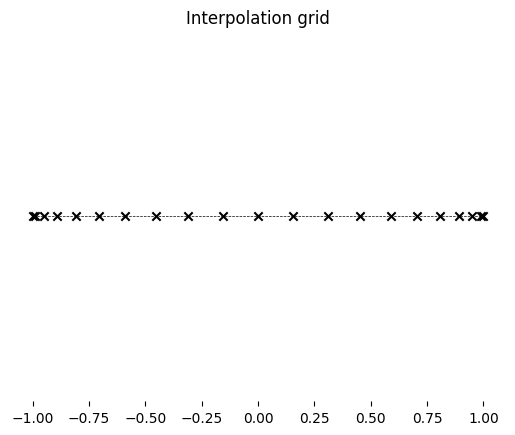

In [5]:
plot_grid(grd)

One-dimensional interpolation grid for polynomial of degree $20$ contains $21$ interpolation points/nodes.

### From Lagrange polynomial to Newton polynomial

Evaluate the original function at the unisolvent nodes to obtain the coefficients for a polynomial in the Lagrange basis:

In [6]:
lag_coeffs = fun(grd.unisolvent_nodes)

We know have all the minimum ingredients to construct a fully specified Minterpy polynomial, namely: a multi-index set and the corresponding coefficients (in this case, the coefficients in the Lagrange basis).

To construct a `LagrangePolynomial`

In [7]:
lag_poly = mp.LagrangePolynomial(
    multi_index=mi,
    coeffs=lag_coeffs,
)

While the Lagrange basis is the most intuitive basis for function approximation, in Minterpy you can't do much with such polynomials. For instance, you can't even evaluate them.

More features are open to you once you transform it to the Newton basis:

In [8]:
nwt_poly = mp.LagrangeToNewton(lag_poly)()  # Call the instance to execute the transformation!

Polynomials in the Newton basis can be evaluated:

In [9]:
nwt_poly(np.array([-0.75, 0.0, 0.5]))

array([ 9.99999999e-01, -1.71378436e-24,  1.02799516e-09])

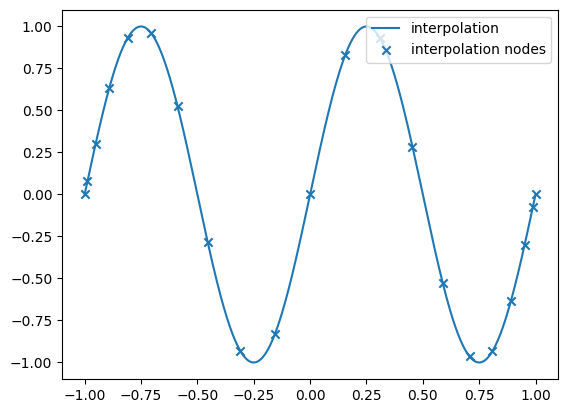

In [10]:
plot_poly(nwt_poly)

## Basic arithmetics

Minterpy supports basic arithmetics operation involving polynomials, namely: addition, subtraction, and multiplication between polynomials and polynomials and polynomials and real scalar numbers.

Currently, only polynomials in the Newton basis have all these operations.

### Addition and subtraction

Adding and subtracting a scalar real number to and from a polynomial returns a polynomial:

In [11]:
nwt_poly + 5.0

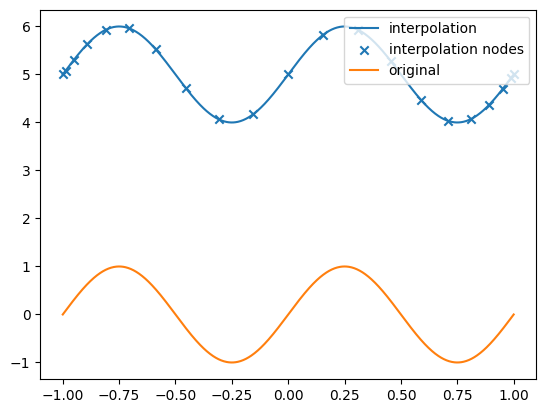

In [12]:
plot_poly(nwt_poly + 5.0, fun)

In [13]:
nwt_poly - 5.0

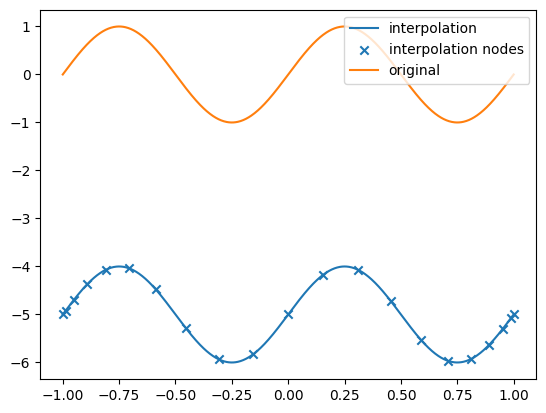

In [14]:
plot_poly(nwt_poly - 5.0, fun)

Before moving on, let's create another polynomial representing a linear function:

In [15]:
def fun_x(xx):
    return xx

In [16]:
mi_x = mp.MultiIndexSet.from_degree(1, 1)
grd_x = mp.Grid(mi_x)
lag_coeffs_x = fun_x(grd_x.unisolvent_nodes)
lag_poly_x = mp.LagrangePolynomial(mi_x, lag_coeffs_x)
nwt_poly_x = mp.LagrangeToNewton(lag_poly_x)()

A Minterpy polynomial may be added with another polynomial; the result is also a polynomial:

In [17]:
nwt_poly + nwt_poly_x

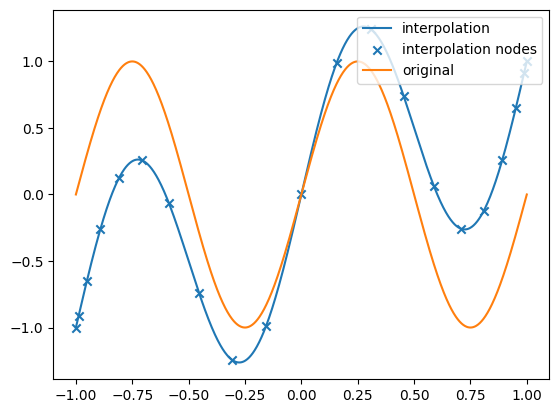

In [18]:
plot_poly(nwt_poly + nwt_poly_x, fun)

...as well as subtraction by a polynomial:

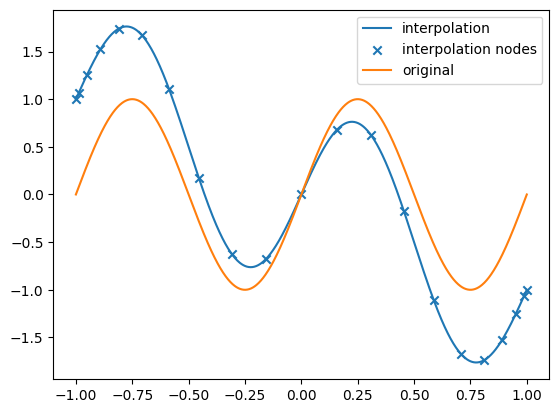

In [19]:
plot_poly(nwt_poly - nwt_poly_x, fun)

### Multiplication

As with subtraction and addition, Minterpy polynomials may be multiplied with a real scalar number

In [20]:
nwt_poly * 2.5

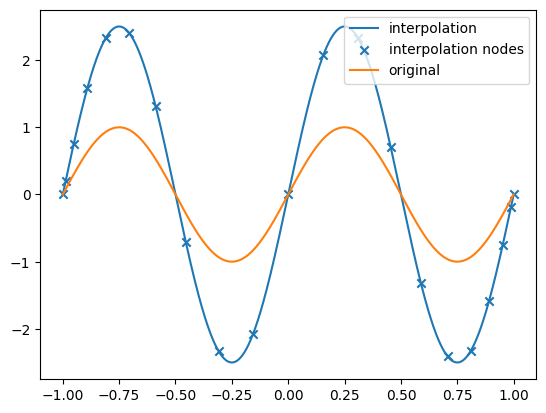

In [21]:
plot_poly(nwt_poly * 2.5, fun)

...and another polynomial:

In [22]:
nwt_poly * nwt_poly_x

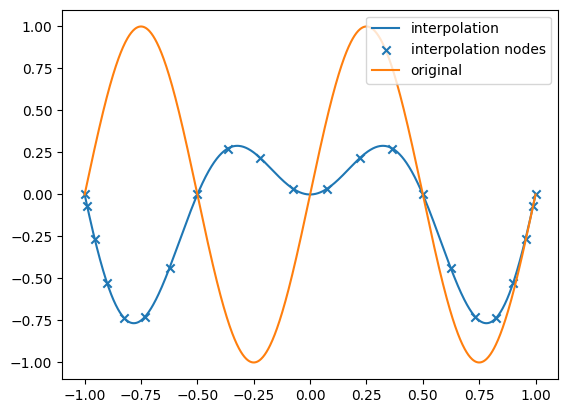

In [23]:
plot_poly(nwt_poly * nwt_poly_x, fun)

## Basic calculus

Minterpy supports basic calculus operations with polynomials, namely: differentiation and definite integration.

Differentiating a polynomial with a specified dimension and order of derivative can be done with the `partial_diff()` method attached to instances of `NewtonPolynomial`:

- `nwt_poly.partial_diff(0)` means $\frac{\partial f}{\partial x_1}$
- `nwt_poly.partial_diff(0, 2)` means $\frac{\partial^2 f}{\partial x^2_2}$
- `nwt_poly.partial_diff(1, 3)` means $\frac{\partial^3 f}{\partial x^3_1}$

Note that the dimension is zero-indexed (i.e., $0$ is the first dimension index).

Calling the method returns a differentiated polynomial in the corresponding basis.

Because we have one-dimensional function, calling the method basically returns $\frac{d^nf}{dx^n}$:

In [24]:
nwt_poly_diff = nwt_poly.partial_diff(0)  # df/dx
nwt_poly_diff

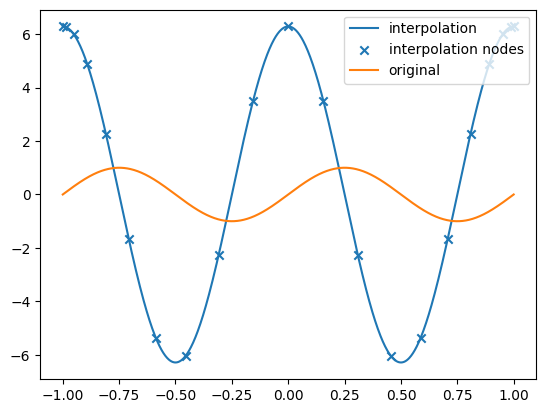

In [25]:
plot_poly(nwt_poly_diff, fun)

Definite integration of a polynomial over a specified domain may be computed via the method `integrate_over()`. By default, the integration is carried out over the whole domain $[-1, 1]^m$. Definite integration returns a number instead of a polynomial:

In [26]:
nwt_poly.integrate_over()

3.0042630706433274e-16

The boundary of integration in $[-1, 1]^m$ can be adjusted by passing the `bounds` arguments (the first argument). For instance integrating the polynomial from $-1.0$ to $0.75$ yields

In [27]:
nwt_poly.integrate_over([-1, 0.75])

0.15915494307982642

PS: Polynomials in Minterpy are defined in $[-1, 1]^m$. If manual transformation is carried out bringing the function from arbitrary domain $[a_1, b_1] \times \ldots \times [a_m, b_m]$ you have to be careful with the change of domain when differentiating and integrating.

## Two-dimensional function approximations

Higher-dimensional functions may be approximated with Minterpy polynomials with similar approach.

Consider now the two-dimensional Runge function:
$$
f(x_1, x_2) = \frac{1}{1 + 4 (x_1^2 + x_2^2)}, \; x_1, x_2 \in [-1, 1]
$$


In [28]:
def runge(xx):
    return 1 / (1 + 4 * np.sum(xx**2, axis=1))

As before we start with defining a multi-index set:

In [29]:
mi_2d = mp.MultiIndexSet.from_degree(
    spatial_dimension=2,
    poly_degree=5,
    lp_degree=2.0,
)

For higher-dimension, we have another parameter in the specification of the multi-index set, i.e., `lp_degree`. Multi-index sets constructed from `from_degree()` is _complete_ in the sense that the set contains _all_ the exponents $\boldsymbol{\alpha} = (\alpha_1, \ldots, \alpha_m) \in \mathbb{N}^m$ such that the $l_p$-norm $\lVert \boldsymbol {\alpha} \rVert_p = (\alpha_1^p + \ldots + \alpha_m^p)^{\frac{1}{p}}\leq n$, where $m$, $n$, $p$ are the `spatial_dimension`, 
`poly_degree`, and `lp_degree`, respectively.

If not specified, `lp_degree` is set to $2.0$.

The complete multi-index set defined above contains the following elements along with the resulting interpolation grid in two-dimension:

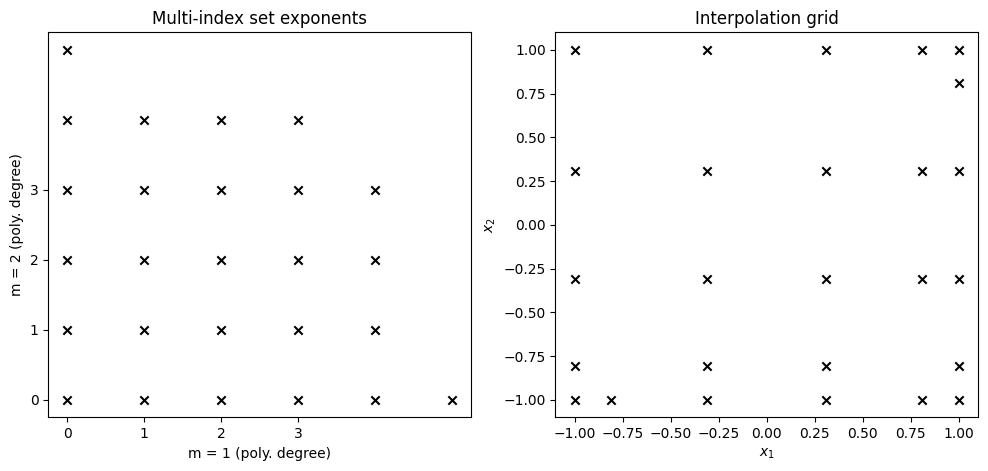

In [30]:
plot_multi_index(mi_2d)

We can compare the above for `lp_degree` of $1.0$ (total degree set / grid):

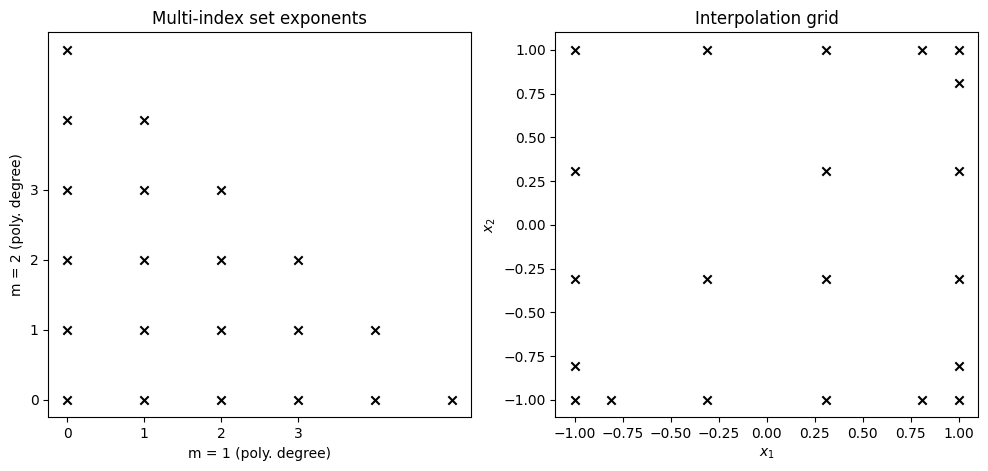

In [31]:
plot_multi_index(mp.MultiIndexSet.from_degree(2, 5, 1.0))

...and $\infty$ (full tensorial multi-index set and grid):

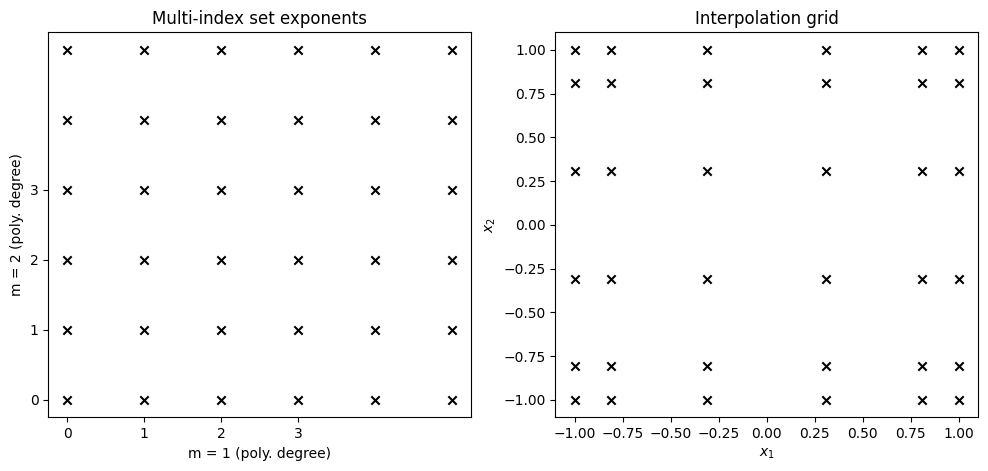

In [32]:
plot_multi_index(mp.MultiIndexSet.from_degree(2, 5, np.inf))

Once a multi-index set is specified, we obtain the coefficients of the polynomial in the Lagrange basis:

In [33]:
grd_2d = mp.Grid(mi_2d)
lag_coeffs_2d = runge(grd_2d.unisolvent_nodes)

Then create a polynomial in the Lagrange basis:

In [34]:
lag_poly = mp.LagrangePolynomial(mi_2d, lag_coeffs_2d)

...before transforming it to the Newton polynomial:

In [35]:
nwt_poly_2d = mp.LagrangeToNewton(lag_poly)()

The resulting `NewtonPolynomial` behave the same as before; the main difference is that now everything is in two-dimension.

In [36]:
nwt_poly_2d(
    np.array([
        [0.5, 0.75],
        [-0.5, 0.0],
    ])
)

array([0.23296118, 0.51714189])

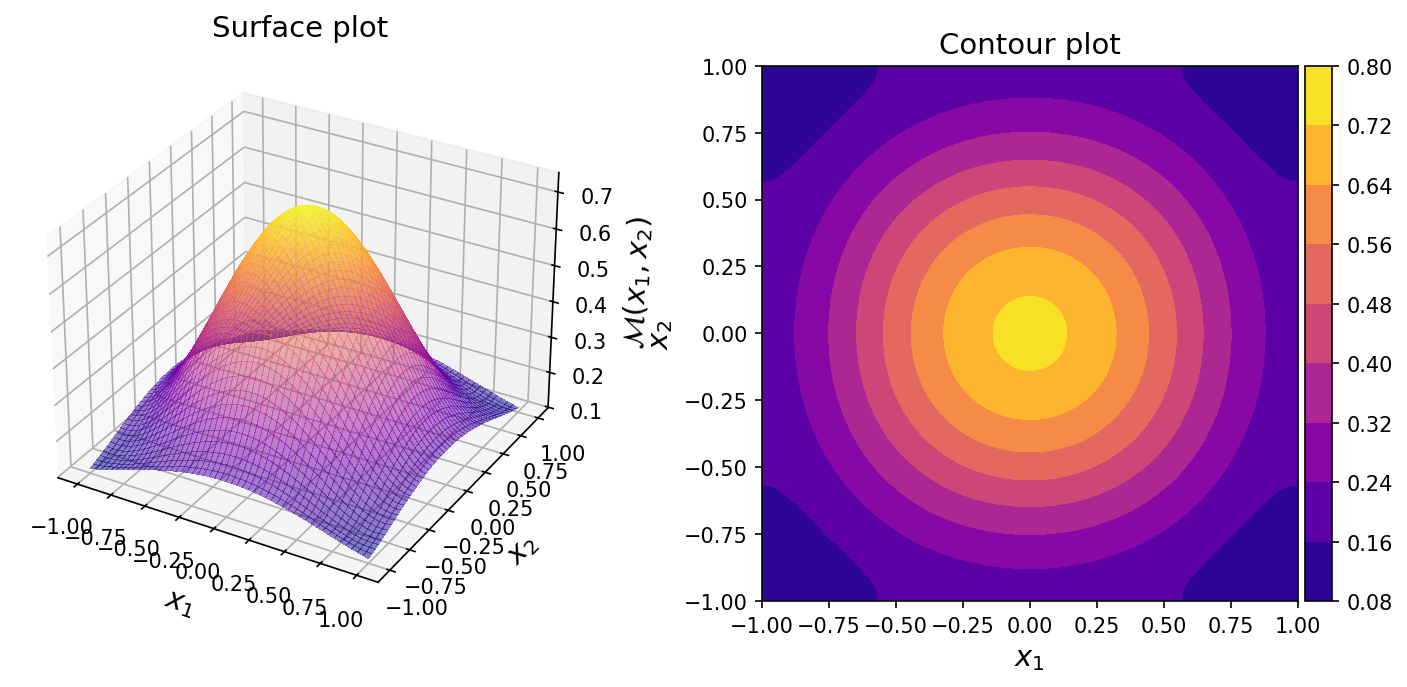

In [37]:
plot_poly(nwt_poly_2d)